# Time Series Anomaly Detection

## Exercise

* add comments
* add markdown
* add docstrings

### Imports

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
# style.use('fivethirtyeight')
%matplotlib inline

pd.plotting.register_matplotlib_converters()

<div class="alert alert-block alert-info">
<b>Goal:</b>  
<br>- Anomaly in number of web pages accessed in a day by a user. A bot copying curriculum? 
<br>- Before we look by user, let's make it work by analyzing over all users.
</div> 

### Acquire 

In [2]:
#Acquire data from txt/csv and make into dataframe
colnames = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']
df = pd.read_csv("anonymized-curriculum-access.txt", 
                 sep="\s", 
                 header=None, 
                 names = colnames, 
                 usecols=[0, 2, 3, 4, 5])
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [3]:
#column and data type summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       900223 non-null  object 
 1   endpoint   900222 non-null  object 
 2   user_id    900223 non-null  int64  
 3   cohort_id  847330 non-null  float64
 4   source_ip  900223 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 34.3+ MB


### Prepare 

In [4]:
#change date/time from object to datetime type
df.date = pd.to_datetime(df.date)
#set date/time as the index
df = df.set_index(df.date)
#assign the resampled endpoint by day count to pages variable
pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

<AxesSubplot:xlabel='date'>

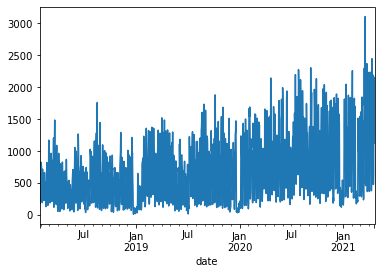

In [5]:
#plot endpoint resampled by day
pages.plot()

<div class="alert alert-block alert-info">No need to split because we are not modeling, we are using statistics to identify low probability cases.
</div>   

In [ ]:
# end_train = '2020-06-30'
# start_test = '2020-07-01'

# train = pages[:end_train]
# test = pages[start_test:]

In [ ]:
# plt.figure(figsize=(12, 6))
# plt.plot(train)
# plt.plot(test)
# plt.show()

In [ ]:
pages.isnull().sum()

## Exponential Moving Average

SMA time series are much less noisy than the time series of the original data points. 
The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. 

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this: 

$EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$

Where: 

- M = Number of time periods, span of the window

- $t_{0}$ = Latest value

- $t-1$ = Previous value

- $EMA_{t-1}$ = Exponential moving average of previous day. 

- The multiplier: $\alpha = \frac{2}{M+1}$

However, we will use the pandas ewm (Exponential Weighted functions) to compute our EMA. 
So we just need to define the following: 

- M = `span` argument = number of time periods. We will try 7 days, 14 days, and 30 days. 

- Notice how there are no missing values. ewm() will use as many values are available to compute the mean. So if the span is 7 days, but it is on the first day of data available, the EMA will equal the first value. 

In [ ]:
# 7 day EMA
ema_7d = train.ewm(span=7).mean()
ema_7d.head()

In [ ]:
# 14 days EMA
ema_14d = train.ewm(span=14).mean()
ema_14d.head()

In [ ]:
# 30 days EMA
ema_30d = train.ewm(span=30).mean()
ema_30d.head()

In [ ]:
# 90 days EMA
ema_90d = train.ewm(span=90).mean()
ema_90d.head()

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(train.index, train, label='Size (MB)', alpha=.5)

ax.plot(train.index, ema_7d, label = '7-day EMA')
ax.plot(train.index, ema_14d, label = '14-day EMA')
ax.plot(train.index, ema_30d, label = '30-day EMA')
ax.plot(train.index, ema_90d, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()

## Bollinger Bands and %b

**Bollinger Bands**

- a volatility indicator and commonly used in stock market trading. 

- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.  

**Midband**

- The Exponential Moving Average

- `midband = train.ewm(span=30).mean()`

**Upper & Lower Band**

- UB/LB = Midband +/- stdev * K

- `stdev = train.ewm(span=30).std()` 

- K = the number of standard deviations to go up and down from the EMA

**%b, Percent Bandwidth**

- Shows where the last value sits in relation to the bands

- $\%b = \frac{last-LB}{UB-LB}$ 

- %b > 1 => point lies above UB

- %b < 0 => point lies below LB

- %b == .5 => point lies on the midband. 

**Bandwidth** 

- The width of the bands

- $Bandwidth = \frac{(UB-LB)}{Midband}$


In [ ]:
# set the window span
span = 30

# compute midband
midband = train.ewm(span=span).mean()

midband.head()

In [ ]:
# compute exponential stdev
stdev = train.ewm(span=span).std()

stdev.head()

In [ ]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3
ub

In [ ]:
lb

In [ ]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()

In [ ]:
train = pd.concat([train, midband, bb], axis=1)
train.columns = ['pages', 'midband', 'ub', 'lb']
train.head()

Plot the bands

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, train.pages, label='Number of Pages')

ax.plot(train.index, train.midband, label = '30-day EMA/midband')
ax.plot(train.index, train.ub, label = 'Upper Band')
ax.plot(train.index, train.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Size (GB)')

plt.show()

Compute %b

$\%b = \frac{last-LB}{UB-LB}$ 

Each row/time period, will have a %b value that answers the question, where does this point sit with respect to the expected value when considering the values before it. For example, we could take the last value in train and manually compute %b: 

In [ ]:
# get the last measure of gb
last_measure = train.iloc[-1].pages
last_measure

In [ ]:
# get the lower band value on the last date
last_lb = train.iloc[-1].lb
last_lb

In [ ]:
# get the upper band value on the last date
last_ub = train.iloc[-1].ub
last_ub

In [ ]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

In [ ]:
train.tail()

So, to compute for each point in time: 

In [ ]:
train['pct_b'] = (train['pages'] - train['lb'])/(train['ub'] - train['lb'])

train.head()

Now, where do we see anomalies? We will search for %b values > 1. We don't need to search for values < 0 because with this example, a low extreme is not something we are concerned about. 

In [ ]:
train[train['pct_b']>1]

## Pull it all together!

1. acquire
2. prep with user
3. compute features
    - compute midband
    - compute standard deviation
    - compute upper & lower band
    - create df with metrics
    - compute %b
    - add user_id to dataframe
4. Plot
5. search for anomalies

In [ ]:
def acquire(file_name, column_names):
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['endpoint'].resample('d').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()
    
def find_anomalies(df, user, span, weight):
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]

In [ ]:
file_name = "anonymized-curriculum-access.txt"
column_names = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']
df = acquire(file_name, column_names)
df.head()

Test on a single user

In [ ]:
user = 1
span = 30
weight = 6
user_df = find_anomalies(df, user, span, weight)

anomalies = pd.DataFrame()
user_df = find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis=0)

In [ ]:
span = 30
weight = 3.5

anomalies = pd.DataFrame()
for u in list(df.user_id.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [ ]:
anomalies

In [ ]:
anomalies.user_id.value_counts()